In [23]:
#don't change this cell
import pandas as pd
import os
import sys
import numpy as np
from mytorch import Tensor, Model
from mytorch import activation as active_func
from mytorch import loss as loss_func
from mytorch import optimizer as optim
from mytorch import layer as nn
from mytorch import util
from torchsummary import summary
from tqdm import tqdm
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor
import matplotlib.pylab as plt

In [24]:
#don't change this cell
# device = "cuda" if mytorch.cuda.is_available() else "cpu"
device = "cpu"

In [25]:
def to_one_hot(labels: Tensor, num_classes: int) -> Tensor:
  one_hot = np.zeros((labels.data.size, num_classes), dtype=np.float64)
  one_hot[np.arange(labels.data.size), labels.data.astype(int)] = 1.0
  return Tensor(one_hot, requires_grad=labels.requires_grad, depends_on=labels.depends_on)


In [26]:
transform = ToTensor()

"Set download=True to download dataset online"
data_path = './data_'
mnist_train = FashionMNIST(data_path, train=True, download=True, transform=transform)
mnist_test = FashionMNIST(data_path, train=False, download=True, transform=transform)
X_train = np.array(np.zeros(shape=(60000,1,28,28)))
Y_train = np.array(np.zeros(shape=(60000,)))
X_test = np.array(np.zeros(shape=(10000,1,28,28)))
Y_test = np.array(np.zeros(shape=(10000,)))
for i in range (0, 60000):
  image, label = mnist_train[i]
  X_train[i] = image.data
  Y_train[i] = label

for i in range (0, 10000):
  image, label = mnist_test[i]
  X_test[i] = image.data
  Y_test[i] = label


X_train = Tensor(X_train, True, depends_on=[])
Y_train = Tensor(Y_train, True, depends_on=[])
X_test = Tensor(X_test, True, depends_on=[])
Y_test = Tensor(Y_test, True, depends_on=[])
Y_train_to_one_hot = to_one_hot(Y_train, 10)
Y_test_to_one_hot = to_one_hot(Y_test, 10)

print(f"\nTraining samples: {X_train.data.shape}, Testing samples: {X_test.data.shape}")


Training samples: (60000, 1, 28, 28), Testing samples: (10000, 1, 28, 28)


In [27]:
#TODO Define your model
class MyModel(Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3,3), padding=(2,2))
        self.conv3 = nn.Conv2d(32, 64, kernel_size=(3,3), padding=(2,2))
        self.maxpool2 = nn.MaxPool2d(1,2,kernel_size=(4, 4), stride=(4, 4))
        self.fc1 = nn.Linear(4096, 256)
        self.fc3 = nn.Linear(256, 10)
        self.relu = active_func.relu
        self.softmax = active_func.softmax

    def forward(self, x: Tensor):
        x = self.conv1(x)
        x = self.relu(x)
        # x = self.dropout(x)

        x = self.conv3(x)
        x = self.relu(x)
        # x = self.dropout(x)

        x = self.maxpool2(x)
        x = util.flatten(x,1)

        x = self.fc1(x)
        x = self.relu(x)
        # x = self.dropout(x)

        x = self.fc3(x)
        x = self.softmax(x)
        return x


In [28]:
model = MyModel()

print(model.summary())

conv1:  conv 2d - total params: 9 - kernel: (3, 3), stride: (1, 1), padding: (2, 2)
conv3:  conv 2d - total params: 9 - kernel: (3, 3), stride: (1, 1), padding: (2, 2)
maxpool2:  max pool 2d - kernel: (4, 4), stride: (4, 4), padding: (1, 1)
fc1:  linear - total param: 1048576 - in: 4096, out: 256
fc3:  linear - total param: 2560 - in: 256, out: 10
None


In [29]:
def one_epoch_learning(
    model: Model,
    optimizer: optim.Optimizer,
    X_train: Tensor,
    Y_train: Tensor,
    Y_without_hot:Tensor,
    loss_function,
    batch_size: int
) -> int:
    accs = 0
    input_size = X_train.data.shape[0]
    for start in range(0, input_size, batch_size):
        end = min(start + batch_size, input_size)
        data = Tensor(X_train.data[start:end])
        label = Tensor(Y_train.data[start:end])
        predictions = model(data)
        optimizer.zero_grad()
        loss = loss_function(predictions, label)
        # print(f"loss = {loss}")
        loss.backward()
        optimizer.step()
        accs += np.sum(np.argmax(predictions.data, 1) == Y_without_hot.data[start: end])

    return accs


In [30]:
#don't change this cell
def calculate_accuracy(
    model: Model,
    X_test,
    Y_test,
    batch_size,
) -> int:
    accs = 0
    input_count = X_test.data.shape[0]
    for i in range(0, input_count, batch_size):
        j = min (i + batch_size, input_count)
        data= X_test[i:j]
        label= Y_test[i:j]
        res: Tensor = model(data)
        accs += np.sum(np.argmax(res.data,1)==np.argmax(label.data,1))
    return accs

In [31]:
def train(
    model: Model,
    loss_function,
    X_train,
    Y_train,
    Y_without_hot,
    X_test,
    Y_test,
    optimizer: optim.Optimizer,
    train_batch_size: int,
    test_batch_size: int,
    epoch: int,
):
    results_train = []
        res_train = one_epoch_learning(model,optimizer,X_train,Y_train,Y_without_hot,loss_function, train_batch_size)
        results_train.append(res_train / Y_train.shape[0])
        res_test = calculate_accuracy(model, X_test, Y_test, test_batch_size)
        results_test.append(res_test / Y_test.shape[0])
    return results_train, results_test

In [32]:
#TODO set EPOCH and optimizer and loss function
EPOCH = 5
train_batch_size = 64
test_batch_size = 64
optimizer = optim.SGD(model.parameters(), learning_rate=0.001)
loss = loss_func.CategoricalCrossEntropy
train_accs, test_accs = train(model, loss, X_train, Y_train_to_one_hot,Y_train, X_test, Y_test_to_one_hot, optimizer, train_batch_size, test_batch_size, EPOCH)

100%|██████████| 5/5 [39:20<00:00, 472.12s/it]


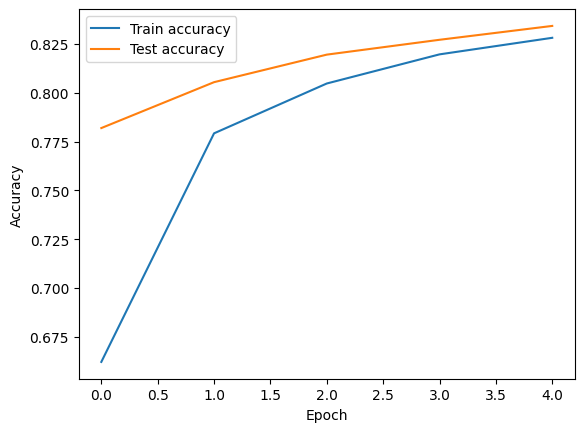

In [33]:
#don't change this cell
plt.plot(train_accs, label="Train accuracy")
plt.plot(test_accs, label="Test accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [34]:
#don't change this cell
print(f"final train acc = {train_accs[-1]:.5f}")
print(f"final test acc = {test_accs[-1]:.5f}")
print(f"max train acc = {max(train_accs):.5f}")
print(f"max test acc = {max(test_accs):.5f}")
print(f"min train acc = {min(train_accs):.5f}")
print(f"min test acc = {min(test_accs):.5f}")

final train acc = 0.82812
final test acc = 0.83420
max train acc = 0.82812
max test acc = 0.83420
min train acc = 0.66215
min test acc = 0.78190
